In [1]:
import pandas as pd 
import numpy as np
import yfinance as yf
from datetime import datetime as dt
from plotnine import *
from mizani.formatters import percent_format

In [2]:
tickerlist = ['UNH', 'MSFT', 'GS', 'HD', 'CAT', 'CRM', 'MCD',
               'V', 'AMGN', 'TRV', 'AXP', 'BA', 'HON', 'JPM',
                 'IBM', 'AAPL', 'AMZN', 'JNJ', 'PG', 'CVX',
                   'MRK', 'DIS', 'NKE', 'MMM', 'KO', 'WMT', 
                   'DOW', 'CSCO', 'INTC', 'VZ']
# inputDf = yf.download(tickers=tickerlist,period='5y',interval='1mo') # Data has been stored in a pickle file and can be read using below line
#  notice that following code could be used instead of specifying interval:  .resample("m").last() 
inputDf = pd.read_pickle(r'/Users/asbjornfyhn/Desktop/Emp Fin/AEF/Exercises/DowJonesDecomp.pkl') 
print(inputDf.head(5))


                           Adj Close                                     \
                                AAPL        AMGN       AMZN         AXP   
Date                                                                      
2019-03-01 00:00:00-05:00  45.716148  163.036499  89.037498  101.854408   
2019-04-01 00:00:00-04:00  48.296196  153.888336  96.325996  109.244225   
2019-05-01 00:00:00-04:00  42.134926  143.058090  88.753502  107.274269   
2019-06-01 00:00:00-04:00  47.817776  159.506424  94.681503  115.438400   
2019-07-01 00:00:00-04:00  51.470795  161.497223  93.338997  116.308098   

                                                                          \
                                   BA         CAT         CRM       CSCO   
Date                                                                       
2019-03-01 00:00:00-05:00  372.486542  120.167107  158.369995  46.391247   
2019-04-01 00:00:00-04:00  368.843872  123.652679  165.350006  48.075390   
2019-05-01 00:00:00

In [3]:
df = (inputDf[['Adj Close']].stack()
      .reset_index()
      .rename(columns={'level_1':'ticker',
                       'Date':'date',
                       'Adj Close':'adj_close'})
      .sort_values(['ticker', 'date'])
      .set_index('date')
) 
# 
df['log_return'] = df.groupby('ticker')['adj_close'].apply(lambda x: np.log(x / x.shift(1))).values
print(df.head(5))

                          ticker  adj_close  log_return
date                                                   
2019-03-01 00:00:00-05:00   AAPL  45.716148         NaN
2019-04-01 00:00:00-04:00   AAPL  48.296196    0.054901
2019-05-01 00:00:00-04:00   AAPL  42.134926   -0.136476
2019-06-01 00:00:00-04:00   AAPL  47.817776    0.126520
2019-07-01 00:00:00-04:00   AAPL  51.470795    0.073617


In [4]:
retVec = df.groupby('ticker')['log_return'].mean().values
covMatrix = df.reset_index().dropna().pivot(index='date',columns='ticker',values='log_return').cov().values

In [5]:
no_obs = len(retVec) # length of return vector
mu = retVec.T   # transpose to row vector instead of column vetor 
iota = np.ones(no_obs).T # row vector of ones 
sigma_inv = np.linalg.inv(covMatrix) # inverse of the covariance matrix

In [6]:
#
mvp_weights = sigma_inv @ iota #sigma_inv % iota # Alternatively:  
mvp_weights = mvp_weights / sum(mvp_weights)

#
mvp_return = mu @ mvp_weights 
mvp_var = mvp_weights.T @ covMatrix @ mvp_weights
mvp_vol = np.sqrt(mvp_var)
mvp_vol_ann = mvp_vol*np.sqrt(12)

# Efficient portfolio 

\begin{align}
    w = w_{mvp} + \frac{\tilde{\lambda}}{2} (\sigma^{-1} * \mu - D/C * \sigma^{-1} * \iota)
\end{align}
where 
\begin{align}
    C = \iota' * \sigma^{-1} * \iota, \;\; D = \iota' * \sigma^{-1} * \mu, \;\; E = \mu' * \sigma^{-1} * \mu 
\end{align}
and 
\begin{align}
    \tilde{\lambda} = 2 * ( \bar{\mu} * - D/C ) / (E - D^2/C)
\end{align}
 a

In [7]:
mu_bar = mvp_return*2
C = iota.T @ sigma_inv @ iota
D = iota.T @ sigma_inv @ retVec
E = retVec.T @ sigma_inv @ retVec
lambda_tilde = 2 * (mu_bar - D/C) / (E-D**2/C)
efp_weights = mvp_weights + lambda_tilde/2 * (sigma_inv@retVec - D* mvp_weights ) #/C * sigma_inv @ iota)

#
efp_return = retVec.T @ efp_weights 
efp_var = efp_weights.T @ covMatrix @ efp_weights
efp_vol = np.sqrt(efp_var)
efp_vol_ann = efp_vol*np.sqrt(12)

In [8]:
c_weights = np.linspace(-4,1.5,100)
eff_front_ret = np.nan + np.zeros(len(c_weights))
eff_front_vol = np.nan + np.zeros(len(c_weights))
eff_front_vol_ann = np.nan + np.zeros(len(c_weights))

for i, c in enumerate(c_weights):
  eff_front_weights = c * mvp_weights + (1-c) * efp_weights
  eff_front_ret[i] = retVec.T @ eff_front_weights 
  eff_front_vol[i] = np.sqrt(eff_front_weights.T @ covMatrix @ eff_front_weights)#
  eff_front_vol_ann[i] = eff_front_vol[i] *np.sqrt(12)

results = pd.DataFrame([eff_front_vol_ann,eff_front_ret],index=['vol','ret']).T
results['ret'] = results['ret'] * 12

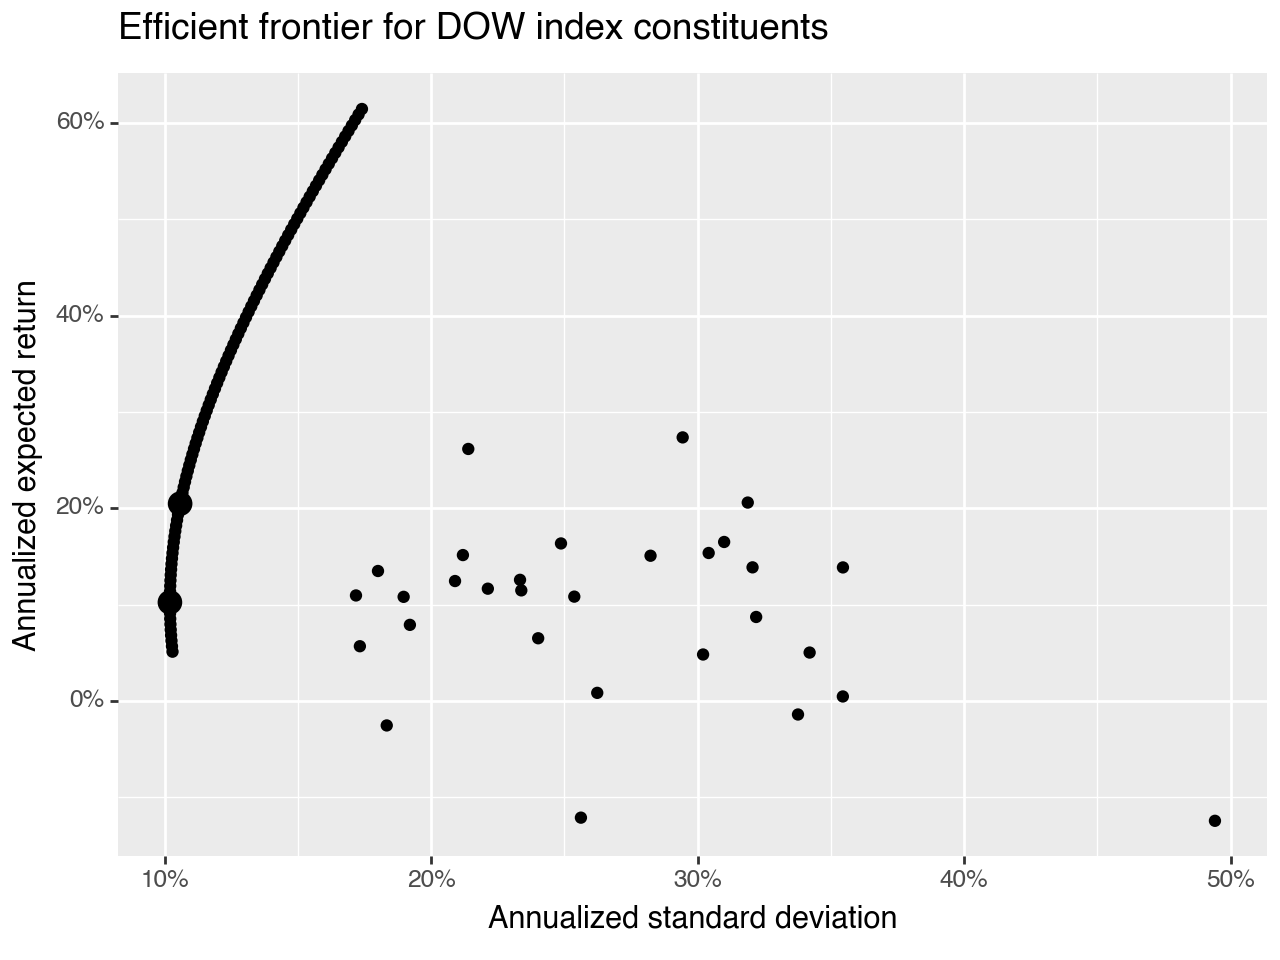

In [9]:
res_figure = (
  ggplot(results, aes(x="vol", y="ret")) +
  geom_point() +
  geom_point(
    pd.DataFrame({"ret": [mvp_return*12, efp_return*12],"vol":[mvp_vol_ann, efp_vol_ann]}),
    size=4)
   +
  geom_point(
    pd.DataFrame({"ret": mu*12,
                  "vol": np.sqrt(np.diag(covMatrix)) * np.sqrt(12)
                  })
  ) +
  labs(x="Annualized standard deviation",
       y="Annualized expected return",
       title="Efficient frontier for DOW index constituents") +
  scale_x_continuous(labels=percent_format()) +
  scale_y_continuous(labels=percent_format())
)
print(res_figure)
